In [3]:
import random
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Twitter API Configuration

In [4]:
import requests
import os
import json

In [5]:
# bearer_token = os.environ['BEARER_TOKEN']

def create_url(tweetIDS):
    ids = "ids=" + tweetIDS
    tweet_fields = "tweet.fields=source,lang,created_at,public_metrics,context_annotations"
    url = "https://api.twitter.com/2/tweets?{}&{}".format(ids, tweet_fields)
    return url


def bearer_oauth(r):
    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2TweetLookupPython"
    return r


def connect_to_endpoint(url):
    response = requests.request("GET", url, auth=bearer_oauth)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()

# Importing Research Data

In [6]:
#Data sourced from: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0182487
df = pd.read_excel('pone.0182487.s003.xlsx')

# Preprocessing

In [7]:
df.head()

,S1 Table - Tweet data and labels,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,We have used the data according to the Twitter...,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,Tweet id,Label,NaN,NaN
4,732113301144883204,0,NaN,NaN


In [8]:
#Fixing columnns and rows
df = df.drop([0,1,2,3])
df = df.drop(['Unnamed: 2','Unnamed: 3'], axis=1)
df = df.set_axis(['id', 'spam'], axis='columns')
df.head()

,id,spam
4,732113301144883204,0
5,732113301182746624,0
6,732113301145014272,0
7,732113301149089794,0
8,732113301178552320,0


In [9]:
#Checking for missing values
print('Missing Values:\n')
print(df.isna().sum())

Missing Values:

id      0
spam    0
dtype: int64


# Visualization

Spam Count: 9945
Good Count: 90055
Spam to Good Ratio: 0.09945


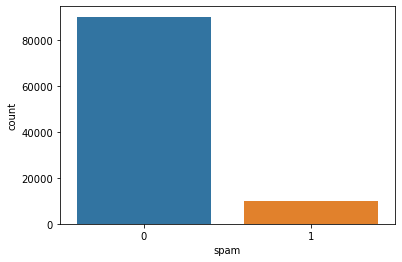

In [10]:
spamCount = df[df['spam']==1].shape[0]
goodCount = df[df['spam']==0].shape[0]

sns.countplot(data=df, x='spam')

print('Spam Count:', spamCount)
print('Good Count:', goodCount)
print('Spam to Good Ratio:', spamCount/(spamCount+goodCount))

# Importing Tweets given Research Data

In [11]:
# tweetIDS = []
# temp = ''
# for count, val in enumerate(df['id']):
#     temp = temp + val + ','
#     if count != 0 and count % 99 == 0:
#         temp = temp[:-1]
#         tweetIDS.append(temp)
#         temp = ''

# tweetJSON = []

# for i in tweetIDS:
#     url = create_url(i)
#     json_response = connect_to_endpoint(url)
#     tweetJSON.append(json_response)

# tweetDF = pd.DataFrame(columns=['id', 'lang', 'created_at', 'source', 'text', 'like_count', 'reply_count', 'quote_count'])

# for val in tweetJSON:
#     for i in val['data']:
#         temp = {
#             'id': i['id'],
#             'lang': i['lang'],
#             'created_at': i['created_at'],
#             'source': i['source'],
#             'text': i['text'],
#             'like_count': i['public_metrics']['like_count'],
#             'reply_count': i['public_metrics']['reply_count'],
#             'quote_count': i['public_metrics']['quote_count']
#         }
        
#         tweetDF = tweetDF.append(temp, ignore_index=True)

# tweetDF.to_csv('tweets.csv')

# Combing Tweet Data and Research Data

In [12]:
tweetDF = pd.read_csv('tweets.csv')

tweetDF['id'] = tweetDF['id'].astype(str)
tweetDF['source'] = tweetDF['source'].astype(str)
tweetDF['text'] = tweetDF['text'].astype(str)


df['id'] = df['id'].astype(str)
df['spam'] = df['spam'].astype(int)

data = pd.merge(tweetDF,df, how='inner', on='id')
data.head()

,Unnamed: 0,id,lang,created_at,source,text,like_count,reply_count,quote_count,spam
0,0,732113301182746624,en,2016-05-16T07:39:47.000Z,Tweetbot for iΟS,RT @odinodin: I just made a tool for inspectin...,0,0,0,0
1,1,732113301145014272,en,2016-05-16T07:39:47.000Z,Twitter for Android,HAPPY BIRTHDAY JOSEPH 💓 @JosephMorgan,0,0,0,0
2,2,732113301149089794,en,2016-05-16T07:39:47.000Z,Twitter for iPad,RT @zeecinema: Yeh inka dopahar ka program hai...,0,0,0,0
3,3,732113305376940032,en,2016-05-16T07:39:48.000Z,Twitter for Android,RT @iitian_kshitij: Actually they have become ...,0,0,0,0
4,4,732113305347612672,en,2016-05-16T07:39:48.000Z,Twitter for iPhone,@JaimesonPaul lock all windows and doors don't...,0,1,0,0


# Preprocessing

In [13]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,id,lang,created_at,source,text,like_count,reply_count,quote_count,spam
0,732113301182746624,en,2016-05-16T07:39:47.000Z,Tweetbot for iΟS,RT @odinodin: I just made a tool for inspectin...,0,0,0,0
1,732113301145014272,en,2016-05-16T07:39:47.000Z,Twitter for Android,HAPPY BIRTHDAY JOSEPH 💓 @JosephMorgan,0,0,0,0
2,732113301149089794,en,2016-05-16T07:39:47.000Z,Twitter for iPad,RT @zeecinema: Yeh inka dopahar ka program hai...,0,0,0,0
3,732113305376940032,en,2016-05-16T07:39:48.000Z,Twitter for Android,RT @iitian_kshitij: Actually they have become ...,0,0,0,0
4,732113305347612672,en,2016-05-16T07:39:48.000Z,Twitter for iPhone,@JaimesonPaul lock all windows and doors don't...,0,1,0,0


In [14]:
#Lowercase expression
lower = lambda x: x.lower()

data['source'], data['text'] = data['source'].apply(lower), data['text'].apply(lower)

#Removing hyperlinks from tweets
removeHyper = lambda x: re.sub(r"http\S+", "", x)

data['text'] = data['text'].apply(removeHyper)


#Removing retweet from tweets
removeRetweet = lambda x: re.sub(r"rt", "", x)

data['text'] = data['text'].apply(removeRetweet)

#Removing @'s from tweets
removeAT = lambda x: re.sub(r"@\S+", "", x)

data['text'] = data['text'].apply(removeAT)

data.head()

,id,lang,created_at,source,text,like_count,reply_count,quote_count,spam
0,732113301182746624,en,2016-05-16T07:39:47.000Z,tweetbot for iοs,i just made a tool for inspecting data in a ...,0,0,0,0
1,732113301145014272,en,2016-05-16T07:39:47.000Z,twitter for android,happy bihday joseph 💓,0,0,0,0
2,732113301149089794,en,2016-05-16T07:39:47.000Z,twitter for ipad,yeh inka dopahar ka program hai! are you wat...,0,0,0,0
3,732113305376940032,en,2016-05-16T07:39:48.000Z,twitter for android,actually they have become middle man too !,0,0,0,0
4,732113305347612672,en,2016-05-16T07:39:48.000Z,twitter for iphone,lock all windows and doors don't investigate ...,0,1,0,0


# Visualization

Spam Count: 3345
Good Count: 43390
Spam to Good Ratio: 0.07157376698405905


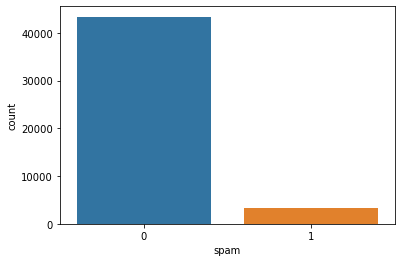

In [15]:
spamCount = data[data['spam']==1].shape[0]
goodCount = data[data['spam']==0].shape[0]

sns.countplot(data=data, x='spam')

print('Spam Count:', spamCount)
print('Good Count:', goodCount)
print('Spam to Good Ratio:', spamCount/(spamCount+goodCount))

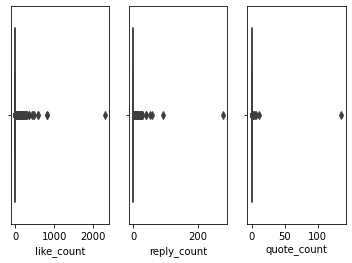

In [16]:
#Checking for outliers
fig, ax =plt.subplots(1,3)
sns.boxplot(x=data['like_count'], ax=ax[0])
sns.boxplot(x=data['reply_count'],ax=ax[1])
sns.boxplot(x=data['quote_count'],ax=ax[2])
plt.show()

In [17]:
#Removing obvious outliers
data = data.drop(data.index[data['like_count']>1000].tolist())  
data = data.drop(data.index[data['reply_count']>100].tolist())  
data = data.drop(data.index[data['quote_count']>50].tolist()) 

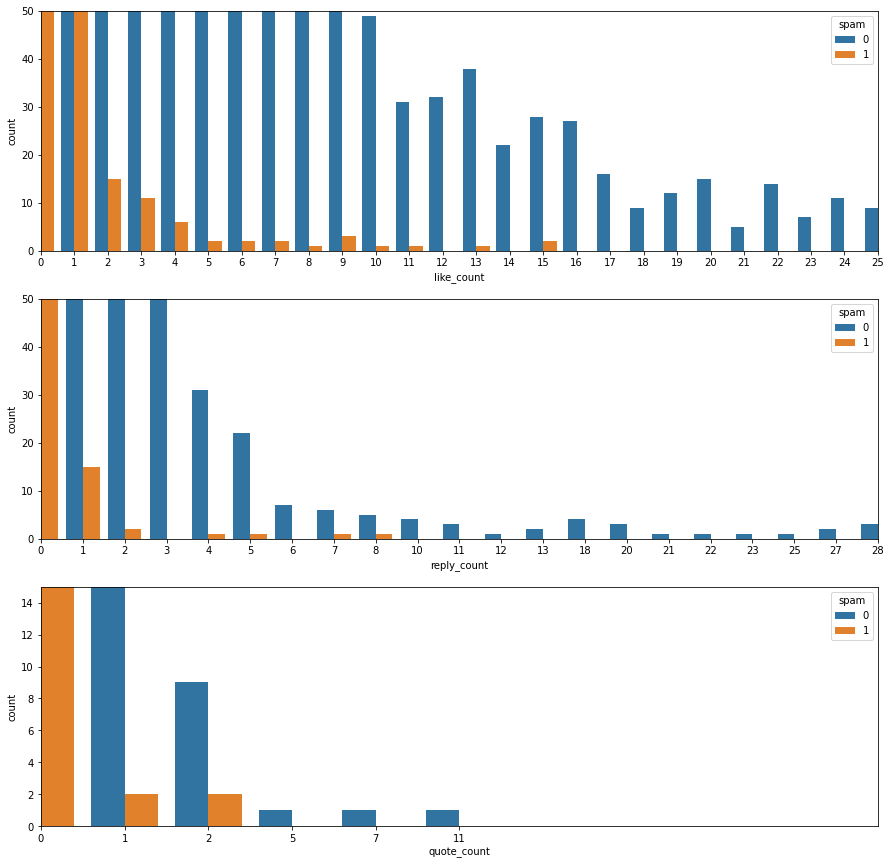

In [18]:
fig, ax = plt.subplots(3,figsize=(15,15))

sns.countplot(x=data['like_count'],hue=data['spam'], ax=ax[0])
ax[0].set_xlim(0,25)
ax[0].set_ylim(0,50)

sns.countplot(x=data['reply_count'],hue=data['spam'], ax=ax[1])
ax[1].set_xlim(0,20)
ax[1].set_ylim(0,50)

sns.countplot(x=data['quote_count'],hue=data['spam'], ax=ax[2])
ax[2].set_xlim(0,10)
ax[2].set_ylim(0,15)

plt.show()

# Predicting SPAM through Tweet Text

### Train Test Split

In [35]:
#For models predicting using text
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['spam'], test_size=1/3, random_state=0)

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_X_train = vectorizer.fit_transform(X_train)
tfidf_X_test  = vectorizer.transform(X_test)

In [97]:
print(X_train.shape,'\n')

vocab, idf = vectorizer.vocabulary_,vectorizer.idf_

# get the first vector out (for the first document)
first_vector_tfidfvectorizer=tfidf_X_test[0]
 
# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=vectorizer.get_feature_names(), columns=["tf_idf"])
df.sort_values(by=["tf_idf"],ascending=False)

(31154,) 



,tf_idf
nope,0.824786
lol,0.565445
00,0.000000
personnel,0.000000
personalized,0.000000
...,...
fayyaz,0.000000
fayre,0.000000
fayette,0.000000
faxts,0.000000


### Logistic Regression

In [20]:
model = LogisticRegression()
model.fit(tfidf_X_train, y_train)

y_pred = model.predict(tfidf_X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     14430
           1       0.96      0.57      0.72      1148

    accuracy                           0.97     15578
   macro avg       0.96      0.79      0.85     15578
weighted avg       0.97      0.97      0.96     15578

[[14404    26]
 [  489   659]]
0.9669405571960457


### Random Forests

In [21]:
model = RandomForestClassifier()
model.fit(tfidf_X_train, y_train)

y_pred = model.predict(tfidf_X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     14430
           1       0.98      0.68      0.81      1148

    accuracy                           0.98     15578
   macro avg       0.98      0.84      0.90     15578
weighted avg       0.98      0.98      0.97     15578

[[14414    16]
 [  363   785]]
0.9756708178200025


# Predicting SPAM through Tweet Source

### Train Test Split

In [22]:
#For models predicting using text
X_train, X_test, y_train, y_test = train_test_split(data['source'], data['spam'], test_size=1/3, random_state=0)

vectorizer = TfidfVectorizer()
tfidf_X_train = vectorizer.fit_transform(X_train)
tfidf_X_test  = vectorizer.transform(X_test)

### Logistic Regression

In [23]:
model = LogisticRegression()
model.fit(tfidf_X_train, y_train)

y_pred = model.predict(tfidf_X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     14430
           1       0.99      0.39      0.56      1148

    accuracy                           0.96     15578
   macro avg       0.97      0.70      0.77     15578
weighted avg       0.96      0.96      0.95     15578

[[14424     6]
 [  695   453]]
0.9550006419309283


### Random Forests

In [24]:
model = RandomForestClassifier()
model.fit(tfidf_X_train, y_train)

y_pred = model.predict(tfidf_X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     14430
           1       0.97      0.42      0.59      1148

    accuracy                           0.96     15578
   macro avg       0.96      0.71      0.78     15578
weighted avg       0.96      0.96      0.95     15578

[[14414    16]
 [  663   485]]
0.9564128899730389


# Predicting SPAM through likes, replies, and quotes

### Train Test Split

In [25]:
subset = data.drop(random.sample(data.index[data['spam']==0].tolist(),40042))

X_train, X_test, y_train, y_test = train_test_split(subset.drop(['id', 'lang', 'created_at', 'spam','text', 'source'], axis=1), subset['spam'], test_size=1/3, random_state=0)

### Logistic Regression

In [26]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.17      0.29      1108
           1       0.54      0.98      0.70      1122

    accuracy                           0.58      2230
   macro avg       0.72      0.57      0.49      2230
weighted avg       0.72      0.58      0.49      2230

[[ 188  920]
 [  23 1099]]
0.5771300448430493


### Random Forests


In [27]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.26      0.40      1108
           1       0.57      0.95      0.71      1122

    accuracy                           0.61      2230
   macro avg       0.70      0.61      0.55      2230
weighted avg       0.70      0.61      0.56      2230

[[ 291  817]
 [  56 1066]]
0.6085201793721973
